# Sentiment Analysis of COVID-19 Tweets: When did the Public Panic Set In?

    Notebook by Allison Kelly - allisonkelly42@gmail.com
    

# Imports

In [95]:
%matplotlib inline

# Generic Imports
import pandas as pd
pd.set_option('display.max_colwidth', 150) # See more text
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time

# Get JSON
import json
import ast

# Text preprocessing libraries
import string
import contractions
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.collocations import *

# Exploratory data analysis libraries
from wordcloud import WordCloud

# Obtain Data

View method to obtain data <a href="https://github.com/akelly66/COVID-Tweet-Sentiment/blob/master/tweet-scraping/COVID-tweets-true.ipynb">here</a>. <br>
<br>The tweet query parameters were as follows:

- <b>Keywords: </b> "coronavirus OR Wuhan virus OR 2019-nCoV OR China flu"<br>
- <b>Date Range: </b> 28 Jan 2020 - 03 Feb 2020<br>
- <b>Location:</b> United States of America<br><br>


In [35]:
df = pd.read_csv("expanded_query_tweets.csv")
df.drop_duplicates(inplace=True)
df = df.query("lang == 'en'")
df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,lang,matching_rules,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,display_text_range,extended_tweet,extended_entities
1,Sun Feb 02 23:59:59 +0000 2020,1224120307717410816,1224120307717410816,"RT @QuestForSense: Amazing Timelapse as China Completes First of Two Hospitals in Wuhan within 10 days having 1,000 beds and 1,400 medical…","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,NaN,NaN,NaN,...,en,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sun Feb 02 23:59:58 +0000 2020,1224120306668883971,1224120306668883971,"RT @selinawangtv: Bloomberg SCOOP on #coronavirus impact: Chinese oil demand said to have dropped by about three million barrels a day, or…","<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",False,NaN,NaN,NaN,NaN,...,en,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sun Feb 02 23:59:58 +0000 2020,1224120305431375872,1224120305431375872,"RT @Marfoogle: I have become Ill. But no worries, Its just stuff related to my existing G.I. issues. So No coronavirus here. I saw emails c…","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,NaN,NaN,NaN,...,en,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sun Feb 02 23:59:58 +0000 2020,1224120305322467329,1224120305322467329,RT @NPRHealth: U.S. Hospitals Unprepared For A Quickly Spreading Coronavirus https://t.co/4LkEEVSqqg,"<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",False,NaN,NaN,NaN,NaN,...,en,[{'tag': None}],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Sun Feb 02 23:59:58 +0000 2020,1224120304731029504,1224120304731029504,"RT @SecAzar: At this time, the risk to Americans remains low, and we are working to keep it that way. We will continue our work to monitor,…","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,NaN,NaN,NaN,...,en,[{'tag': None}],NaN,1.223347e+18,1.223347e+18,"{'created_at': 'Fri Jan 31 20:47:02 +0000 2020', 'id': 1223346974264561665, 'id_str': '1223346974264561665', 'text': 'As part of the Administratio...","{'url': 'https://t.co/eb4YN1H7QN', 'expanded': 'https://twitter.com/SecAzar/status/1223346974264561665', 'display': 'twitter.com/SecAzar/status…'}",NaN,NaN,NaN


In [36]:
print(len(df))
print(df.info())
df.describe()

2375
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2375 entries, 1 to 4396
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 2375 non-null   object 
 1   id                         2375 non-null   int64  
 2   id_str                     2375 non-null   int64  
 3   text                       2375 non-null   object 
 4   source                     2375 non-null   object 
 5   truncated                  2375 non-null   bool   
 6   in_reply_to_status_id      108 non-null    float64
 7   in_reply_to_status_id_str  108 non-null    float64
 8   in_reply_to_user_id        117 non-null    float64
 9   in_reply_to_user_id_str    117 non-null    float64
 10  in_reply_to_screen_name    112 non-null    object 
 11  user                       2375 non-null   object 
 12  geo                        0 non-null      object 
 13  coordinates                0 non-null      

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,contributors,quote_count,reply_count,retweet_count,favorite_count,quoted_status_id,quoted_status_id_str
count,2.375000e+03,2.375000e+03,1.080000e+02,1.080000e+02,1.170000e+02,1.170000e+02,0.0,2375.000000,2375.000000,2375.000000,2375.000000,1.890000e+02,1.890000e+02
mean,1.223425e+18,1.223425e+18,1.223349e+18,1.223349e+18,2.647967e+17,2.647967e+17,NaN,0.065684,0.134737,0.506526,1.038316,1.222812e+18,1.222812e+18
std,1.450457e+14,1.450457e+14,2.524461e+14,2.524461e+14,4.316935e+17,4.316935e+17,NaN,1.009173,1.312387,6.461853,9.356226,2.511830e+15,2.511830e+15
min,1.223394e+18,1.223394e+18,1.221944e+18,1.221944e+18,7.867640e+05,7.867640e+05,NaN,0.000000,0.000000,0.000000,0.000000,1.190002e+18,1.190002e+18
25%,1.223394e+18,1.223394e+18,1.223345e+18,1.223345e+18,7.054162e+07,7.054162e+07,NaN,0.000000,0.000000,0.000000,0.000000,1.222912e+18,1.222912e+18
50%,1.223395e+18,1.223395e+18,1.223391e+18,1.223391e+18,1.344897e+09,1.344897e+09,NaN,0.000000,0.000000,0.000000,0.000000,1.223229e+18,1.223229e+18
75%,1.223395e+18,1.223395e+18,1.223393e+18,1.223393e+18,7.302201e+17,7.302201e+17,NaN,0.000000,0.000000,0.000000,0.000000,1.223373e+18,1.223373e+18
max,1.224120e+18,1.224120e+18,1.224119e+18,1.224119e+18,1.202716e+18,1.202716e+18,NaN,37.000000,36.000000,176.000000,218.000000,1.224101e+18,1.224101e+18


Many of the tweets are truncated due to being retweets. The full, original tweet can be found in the retweeted_status column. The responses from the Twitter API are nested JSON objects, however when I converted them into a dataframe, the nested JSON objects became dictionary-like strings. The following cells will use abstract syntax trees to convert the string to a dictionary (though I'm really not sure why or how it works!) and pull the full text of the original tweet. I believe it's important to the sentiment analysis to interpret the original content as supported by the profile doing the retweeting.

In [37]:
def evaluate(row):
    '''
    This function, when applied to
    the series containing 
    dictionary-like strings will 
    convert each instance to
    actual dictionaries and return
    the dictionary.
    '''
    
    row = ast.literal_eval(row) 
    return row

# Saving dictionaries in new column
df['expanded'] = df.retweeted_status.dropna().apply(evaluate)

In [38]:
# Creating features from dictionary keys in new dataframe
expanded_df = df['expanded'].apply(pd.Series)

# Again, unnesting another dictionary to get to the full_text column
expanded_df = expanded_df.extended_tweet.apply(pd.Series)

# Dropping rows corresponding to original tweets (not retweeted text)
expanded_df = expanded_df.full_text.dropna()

In [39]:
# Joining with original dataframe
df = pd.DataFrame.join(df, expanded_df)

In [40]:
# Swapping NaNs for original tweets in the full text column
df['full_text'].fillna(df['text'],inplace=True)

# Preprocess Tweets

Though the entirety of the dataset is a treasure trove of information, I've singled out just the text portion to process for the sentiment analysis. 

In [41]:
tweet_df = df.loc[:,['full_text']]
tweet_df.head()

,full_text
1,"Amazing Timelapse as China Completes First of Two Hospitals in Wuhan within 10 days having 1,000 beds and 1,400 medical staff to treat those infec..."
2,"Bloomberg SCOOP on #coronavirus impact: Chinese oil demand said to have dropped by about three million barrels a day, or 20% of total consumption...."
3,"I have become Ill. But no worries, Its just stuff related to my existing G.I. issues. So No coronavirus here. I saw emails concerning my visit to ..."
4,RT @NPRHealth: U.S. Hospitals Unprepared For A Quickly Spreading Coronavirus https://t.co/4LkEEVSqqg
5,"At this time, the risk to Americans remains low, and we are working to keep it that way. We will continue our work to monitor, respond to, and mit..."


In [42]:
def remove_url_and_RT(row):
    '''
    This function takes each tweet
    and removes the urls and retweet
    indicator from them.
    '''
    
    row = re.sub(r'http\S+|^RT', "", row)
    row = re.sub(r'\d*',"", row)
    return row

tweet_df.full_text = tweet_df.full_text.apply(remove_url_and_RT)

In [43]:
tweet_df.head()

,full_text
1,"Amazing Timelapse as China Completes First of Two Hospitals in Wuhan within days having , beds and , medical staff to treat those infected with t..."
2,"Bloomberg SCOOP on #coronavirus impact: Chinese oil demand said to have dropped by about three million barrels a day, or % of total consumption. C..."
3,"I have become Ill. But no worries, Its just stuff related to my existing G.I. issues. So No coronavirus here. I saw emails concerning my visit to ..."
4,@NPRHealth: U.S. Hospitals Unprepared For A Quickly Spreading Coronavirus
5,"At this time, the risk to Americans remains low, and we are working to keep it that way. We will continue our work to monitor, respond to, and mit..."


In [44]:
def clean_tweet(tweet):
    
    '''
    This function takes a tweet variable,
    removes punctuation and linebreaks,
    sets all words to lowercase, and 
    returns the cleaned tweet as a single
    variable list.
    '''
    
    # Grabbing most common punctuation symbols and ellipsis symbol
    punctuation_list = list(string.punctuation)+ ["…"] + ['’']
    punctuation_list.remove('#')
    
    
    cleaned_tweet = []
    
    for symbol in punctuation_list:
        
        tweet = tweet.replace(symbol, "").lower()
        
        # Removing trailing characters
        tweet = tweet.rstrip()
        
        # Cleaning non-ASCII characters
        tweet = re.sub("([^\x00-\x7F])+","",tweet)
      
    cleaned_tweet.append(tweet)
    
    return cleaned_tweet

cleaned_tweet_test = clean_tweet(tweet_df.full_text[1])
cleaned_tweet_test        

['amazing timelapse as china completes first of two hospitals in wuhan within  days having  beds and  medical staff to treat those infected with the #coronavirus #coronavirusoutbreak']

In [45]:
def tokenize(clean_tweet):
    
    '''
    This function takes a cleaned tweet,
    joins into one string (if not already),
    runs the tweet through NLTK work tokenizer, 
    removes English stopwords, replaces "us"
    with "usa," removes numbers and returns
    the tokenized tweet in list format.
    '''
    
    joined_tweet = ' '.join(clean_tweet)
    stopwords_list = stopwords.words('english')
    
    tokenizer = TweetTokenizer()
    tokenized_tweet = tokenizer.tokenize(joined_tweet)
    # Removing stopwords
    tokenized_tweet = [word for word in tokenized_tweet if word not in stopwords_list]
    
    # Subbing 'usa' for 'us'
    tokenized_tweet = ['usa' if word == 'us' else word for word in tokenized_tweet]
    
    # Removing numbers
    tokenized_tweet = [word for word in tokenized_tweet if not word.isnumeric()]
    
    return tokenized_tweet

    

tokenized_tweet_test = tokenize(cleaned_tweet_test)
tokenized_tweet_test

['amazing',
 'timelapse',
 'china',
 'completes',
 'first',
 'two',
 'hospitals',
 'wuhan',
 'within',
 'days',
 'beds',
 'medical',
 'staff',
 'treat',
 'infected',
 '#coronavirus',
 '#coronavirusoutbreak']

In [46]:
def lem_tweet(tweet):
    '''
    This function takes a tweet in
    the form of a tokenized
    word list and lemmatizes it.
    '''
    lemmatizer = WordNetLemmatizer()
    
    lemmed_tweet = [lemmatizer.lemmatize(word) for word in tweet]
    
    return lemmed_tweet

lemmed_tweet_test = lem_tweet(tokenized_tweet_test)

In [47]:
def stem_tweet(tweet):
    
    stemmer = SnowballStemmer('english')
    stemmed_tweet = [stemmer.stem(word) for word in tweet]
    
    return stemmed_tweet

stem_test = stem_tweet(lemmed_tweet_test)
stem_test

['amaz',
 'timelaps',
 'china',
 'complet',
 'first',
 'two',
 'hospit',
 'wuhan',
 'within',
 'day',
 'bed',
 'medic',
 'staff',
 'treat',
 'infect',
 '#coronavirus',
 '#coronavirusoutbreak']

In [48]:
def process_tweet(tweet):
    '''
    This function takes an original 
    tweet, cleans, tokenizes, 
    and lemmatizes the tweet.
    '''
    
    cleaned = clean_tweet(tweet)
    tokenized = tokenize(cleaned)
#     stemmed_tweet = stem_tweet(tokenized)
    lemmed_tweet = lem_tweet(tokenized)
    
    return lemmed_tweet

tweet_df['processed_tweets'] = tweet_df['full_text'].apply(process_tweet)

In [49]:
# Resetting index
tweet_df = tweet_df.reset_index().drop('index',axis=1)

In [50]:
tweet_df.head()

,full_text,processed_tweets
0,"Amazing Timelapse as China Completes First of Two Hospitals in Wuhan within days having , beds and , medical staff to treat those infected with t...","[amazing, timelapse, china, completes, first, two, hospital, wuhan, within, day, bed, medical, staff, treat, infected, #coronavirus, #coronaviruso..."
1,"Bloomberg SCOOP on #coronavirus impact: Chinese oil demand said to have dropped by about three million barrels a day, or % of total consumption. C...","[bloomberg, scoop, #coronavirus, impact, chinese, oil, demand, said, dropped, three, million, barrel, day, total, consumption, china, world, large..."
2,"I have become Ill. But no worries, Its just stuff related to my existing G.I. issues. So No coronavirus here. I saw emails concerning my visit to ...","[become, ill, worry, stuff, related, existing, gi, issue, coronavirus, saw, email, concerning, visit, provedence, hospitalhome, first, usa, case, ..."
3,@NPRHealth: U.S. Hospitals Unprepared For A Quickly Spreading Coronavirus,"[nprhealth, usa, hospital, unprepared, quickly, spreading, coronavirus]"
4,"At this time, the risk to Americans remains low, and we are working to keep it that way. We will continue our work to monitor, respond to, and mit...","[time, risk, american, remains, low, working, keep, way, continue, work, monitor, respond, mitigate, spread, #coronavirus, ensure, american, accur..."


# Exploratory Data Analysis



In [51]:
# Combining words from all tweets into one list
all_words_list = [item for sublist in tweet_df.processed_tweets for item in sublist]

# Combining all words into one string
all_words_string = (" ").join(all_words_list)


A preliminary look at the most popular words in all of the tweets can be achieved through a word cloud. 

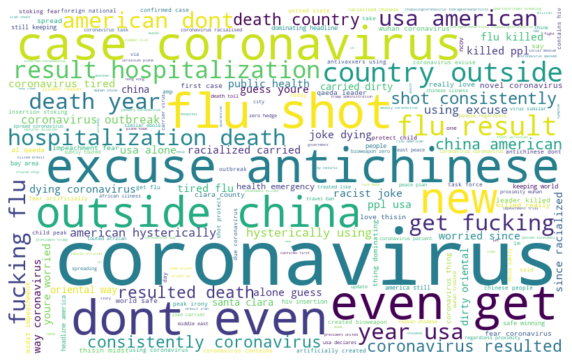

In [52]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(all_words_string)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

At first glance, my impression of the tweets is quite negative. "Antichinese," "hospitalization," and "death" are words that stick out to me the most. 

## Frequency Distributions

NLTK's frequency distribution takes tokens of an entire corpus and shows the number of times each word is used. For this project, I will use all tokens from all tweets as the corpus in which to calculate the frequency distribution.

In [84]:
freqdist = FreqDist(all_words_list)

In [85]:
# Top 20 words in corpus
freqdist.most_common(20)

[('coronavirus', 1823),
 ('#coronavirus', 514),
 ('china', 475),
 ('usa', 426),
 ('flu', 378),
 ('case', 319),
 ('death', 299),
 ('american', 298),
 ('get', 227),
 ('people', 212),
 ('killed', 206),
 ('wuhan', 203),
 ('health', 191),
 ('dont', 187),
 ('country', 181),
 ('chinese', 174),
 ('even', 169),
 ('first', 158),
 ('outbreak', 156),
 ('virus', 151)]

In [79]:
len(freqdist)

5112

The total vocabulary of the tweets is 5,112 individual words. 

Below, we'll identify the top 50 words and calculate the percentage of the corpus each word holds.

In [89]:
# Total word count
tweet_word_count = sum(freqdist.values())
top_50_words = freqdist.most_common(50)

print('Word\t\t\tPercentage of Corpus\n')
for word in top_50_words:
    norm_freq = word[1]/tweet_word_count
    print('{} \t\t\t {:.4}'.format(word[0], round(norm_freq*100,2)))

Word			Use Percentage

coronavirus 			 5.18
#coronavirus 			 1.46
china 			 1.35
usa 			 1.21
flu 			 1.07
case 			 0.91
death 			 0.85
american 			 0.85
get 			 0.65
people 			 0.6
killed 			 0.59
wuhan 			 0.58
health 			 0.54
dont 			 0.53
country 			 0.51
chinese 			 0.49
even 			 0.48
first 			 0.45
outbreak 			 0.44
virus 			 0.43
using 			 0.42
shot 			 0.41
excuse 			 0.41
antichinese 			 0.39
fear 			 0.39
way 			 0.38
confirmed 			 0.38
emergency 			 0.37
year 			 0.36
since 			 0.33
racist 			 0.32
new 			 0.31
public 			 0.31
impeachment 			 0.31
outside 			 0.3
result 			 0.29
world 			 0.29
fucking 			 0.29
hospitalization 			 0.28
consistently 			 0.28
resulted 			 0.28
hysterically 			 0.28
trump 			 0.28
hiv 			 0.27
joke 			 0.26
youre 			 0.26
patient 			 0.26
like 			 0.26
worried 			 0.25
spread 			 0.24


## Bigrams

Calculating bigrams will give us the most common word associations in the entire corpus. 

In [99]:
# Instantiate biram measures method
bigram_measures = BigramAssocMeasures()

# Find and then score associations by frequency
tweet_finder = BigramCollocationFinder.from_words(all_words_list)
tweet_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

# Fifty most common bigrams
tweet_scored[:50]

[(('flu', 'shot'), 0.004007161735868361),
 (('dont', 'even'), 0.003836644215193111),
 (('even', 'get'), 0.003836644215193111),
 (('excuse', 'antichinese'), 0.003836644215193111),
 (('case', 'coronavirus'), 0.003069315372154489),
 (('outside', 'china'), 0.002955637025037656),
 (('country', 'outside'), 0.0028703782647000312),
 (('american', 'dont'), 0.002841958677920823),
 (('american', 'hysterically'), 0.002841958677920823),
 (('china', 'american'), 0.002841958677920823),
 (('consistently', 'coronavirus'), 0.002841958677920823),
 (('coronavirus', 'resulted'), 0.002841958677920823),
 (('death', 'country'), 0.002841958677920823),
 (('death', 'year'), 0.002841958677920823),
 (('flu', 'result'), 0.002841958677920823),
 (('fucking', 'flu'), 0.002841958677920823),
 (('get', 'fucking'), 0.002841958677920823),
 (('hospitalization', 'death'), 0.002841958677920823),
 (('hysterically', 'using'), 0.002841958677920823),
 (('result', 'hospitalization'), 0.002841958677920823),
 (('resulted', 'death'),

## Mutual Information Scores

In [103]:
tweet_finder.apply_freq_filter(10)

tweet_pmi_scored = tweet_finder.score_ngrams(bigram_measures.pmi)
tweet_pmi_scored[:20]

[(('manufactured', 'chinaccp'), 11.780826801602151),
 (('repurposes', 'abbvie'), 11.780826801602151),
 (('talked', 'podcast'), 11.780826801602151),
 (('tearing', 'apart'), 11.780826801602151),
 (('apart', 'defence'), 11.643323277852216),
 (('connection', 'web'), 11.643323277852216),
 (('pharma', 'rally'), 11.643323277852216),
 (('opioid', 'overdose'), 11.643323277852215),
 (('recommended', 'pausing'), 11.643323277852215),
 (('summit', 'opioid'), 11.643323277852215),
 (('trafficking', 'summit'), 11.643323277852215),
 (('dems', 'wasted'), 11.517792395768357),
 (('exceeds', 'prediction'), 11.517792395768357),
 (('measured', 'decisive'), 11.517792395768357),
 (('san', 'francisco'), 11.517792395768357),
 (('taxpayer', 'dollar'), 11.517792395768357),
 (('interesting', 'connection'), 11.50581975410228),
 (('podcast', 'morning'), 11.402315178348422),
 (('jack', 'office'), 11.380288872018422),
 (('charlie', 'kirk'), 11.295399974431913)]

In [55]:
# tweet_df.to_csv('processed_tweets.csv')

## Word Vectorization

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
tweet_list = tweet_df.processed_tweets.apply((' ').join)

In [73]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tweet_list)
dense_matrix = tfidf_matrix.todense()
dense_list = dense_matrix.tolist()

In [74]:
tfidf_df = pd.DataFrame(dense_list, columns = vectorizer.get_feature_names(), index=tweet_list)

In [75]:
tfidf_df.head()

,aa,aaaaggghhhhh,aampe,aanon,aasma,abbvie,abc,abcchicago,abcnews,abcnewsbayarea,...,zerohedge,zerosum,zh,zimbabwe,zimbabwean,zone,zoomers,zoonotic,zorrillaalex,zxrnoh
processed_tweets,,,,,,,,,,,,,,,,,,,,,
amazing timelapse china completes first two hospital wuhan within day bed medical staff treat infected #coronavirus #coronavirusoutbreak,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bloomberg scoop #coronavirus impact chinese oil demand said dropped three million barrel day total consumption china world largest oil importer w outsized impact global energy mkt business quicktake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
become ill worry stuff related existing gi issue coronavirus saw email concerning visit provedence hospitalhome first usa case contact anyone kept distance hospital,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nprhealth usa hospital unprepared quickly spreading coronavirus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
time risk american remains low working keep way continue work monitor respond mitigate spread #coronavirus ensure american accurate uptodate health travel information,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
tfidf_df.shape

(2375, 5007)

From 2,375 tweets, there is a total of 5,007 unique words. This includes hashtags and tagged handles. 